In [10]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

%load_ext autoreload
%autoreload 2

from AutoValidator.model_tester import ModelTester, xy_backtest
from utils.progress import ProgressBar
progress = ProgressBar()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv')
hurst_estimates.set_index('Unnamed: 0', inplace=True)

## KRR Model

## Kernel ridge regression

In [12]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.multioutput import MultiOutputRegressor

In [13]:
model = MultiOutputRegressor(KernelRidge())

In [14]:
horizon = 5

In [15]:
krr_five_min_tester = ModelTester(data, horizon, 0.20)

krr_five_min_tester.add_model(model)

In [16]:
results = {}

In [17]:
horizon = 5
back_horizon = 60

bar = ProgressBar()
bar.set_length(len(data.columns) * 10)

results = {}
test_sets = {}
for column in data.columns:
    results[column] = []
    test_sets[column] = []
    
    col = data[column].values.flatten()
    indexer = np.arange(back_horizon)[None, :] + horizon * np.arange((len(col) - 2 * back_horizon) // horizon)[:, None]
    X = col[indexer]
    
    indexer = back_horizon + np.arange(horizon)[None, :] + horizon * np.arange((len(col) - 2 * back_horizon) // horizon)[:, None]
    y = col[indexer]
        
    for (X_train, X_test, y_train, y_test) in xy_backtest(X, y, 0.2, int(0.8 * len(X)) // 10): 
        # Only use most max_samples training samples
        max_samples = 3000
        max_samples_index = -max_samples
        X_train, y_train = X_train[max_samples_index:], y_train[max_samples_index:]        
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        pred = pred.flatten()
        results[column].append(pred)
        y_test = y_test.flatten()
        test_sets[column].append(y_test)
        
        bar.progress()

Progress: [####################] 100.0%


### Calculate errors

In [233]:
from AutoValidator.ErrorMetrics import *

In [237]:
def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = training_series.shape[0]
    d = np.abs(  np.diff(training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [259]:
def my_MASE(training, test, pred):
    n = len(training)
    
    numerator = np.sum(np.abs(test - pred))
    denominator = (n / (n - 1)) * np.sum(np.abs(train[1:] - train[:-1]))
    print(numerator, denominator)
    
    q = numerator / denominator
    
    return np.mean(np.abs(q))
    

In [366]:
class RandomWalk():
    
    def __init__(self, horizon):
        self.horizon = horizon
    
    def fit(self, train, labels):
        self.train = labels
    
    def predict(self, data):
        comb_data = np.hstack([self.train, data])
        
        results = np.zeros((len(data), self.horizon))
        
        std = np.std(comb_data)
        
        results[:, 0] = data[:]
        
        noise = np.random.normal(0, std, (len(data), self.horizon))
        results += noise        
        
        return results.cumsum(axis=1)
    
    def __repr__(self):
        return 'Random Walk'

    
def calculate_rw_MASE(training, test, pred, horizon):
    naive_estimator = RandomWalk(horizon)
    naive_estimator.fit(training, training)
    naive_estimate = naive_estimator.predict(test[np.arange(0, len(test), horizon)]).flatten()
    
    return np.mean(np.abs(test - pred)) / np.mean(np.abs(test - naive_estimate))
    

In [367]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri, numpy2ri

# Setup to parse to R
pandas2ri.activate()

# Import R libraries
ts         = ro.r('ts')
forecast   = importr('forecast')
thetaModel = importr('forecTheta')
smooth     = importr('smooth')

def calculate_all_errors(training, prediction, actual, horizon):
    errors = {}
    
    # Calculate the error given each metric
    
    # pass the data to R
    rPred    = ts(prediction, frequency = 1 )
    rActual  = ts(actual,     frequency = 1 ) 
    
    # Calculate the errors
    errors['sMAPE'] = thetaModel.errorMetric(obs = rActual, forec = rPred, type = "sAPE", statistic = "M")[0]
    errors['MAE']   = thetaModel.errorMetric(obs = rActual, forec = rPred, type = "AE", statistic = "M")[0]
    errors['MAPE']  = thetaModel.errorMetric(obs = rActual, forec = rPred, type = "APE", statistic = "M")[0]
    errors['RMSE']  = np.sqrt(mean_squared_error(actual, prediction))
    errors['MASE']  = calculate_MASE(training, prediction, actual) 
    errors['MASE1'] = smooth.MASE(rActual, rPred, np.mean(training), digits = 5)[0]
    errors['MASE2'] = MASE(training, actual, prediction)
    errors['MEAN_MASE']: calculate_MASE(training, prediction, actual)
    errors['RW_MASE'] : calculate_rw_MASE(training, prediction, actual, horizon)
    
    return errors

In [356]:
errors = pd.DataFrame(index = data.columns, columns=[[repr(model) + '_' + met for met in metrics.keys()]])

In [368]:
bar.set_length(len(data.columns))
for col in data.columns:
    actual, pred = np.vstack(test_sets[col]).flatten(), np.vstack(results[col]).flatten()
    train = data[col].values.flatten()
    
    print(train.shape, actual.shape, pred.shape)
    
    all_errors = calculate_all_errors(train, pred, actual, horizon)

    for name, value in all_errors.items():
        errors.at[col, repr(model) + '_' + name] = value

    bar.progress()

Progress: [####################] 100.0%


In [369]:
errors.head()

,"MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',\n kernel_params=None),\n n_jobs=1)_RMSE","MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',\n kernel_params=None),\n n_jobs=1)_sMAPE","MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',\n kernel_params=None),\n n_jobs=1)_MAPE","MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',\n kernel_params=None),\n n_jobs=1)_MEAN_MASE","MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',\n kernel_params=None),\n n_jobs=1)_RW_MASE","MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',\n kernel_params=None),\n n_jobs=1)_MAE","MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',\n kernel_params=None),\n n_jobs=1)_MASE","MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',\n kernel_params=None),\n n_jobs=1)_MASE1","MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',\n kernel_params=None),\n n_jobs=1)_MASE2"
window_1_0,165.642,26.1866,73.9395,0.222097,0.131039,65.500843,0.222097,257.07441,2.420507
window_1_1,194.61,25.1885,78.6592,0.245596,0.142124,73.365331,0.245596,189.54450,2.846674
window_1_2,225.555,32.3314,183.227,0.298297,0.168872,97.115373,0.298297,134.56283,2.267045
window_1_3,237.664,30.3395,117.427,0.267713,0.159229,102.830395,0.267713,-246.83018,2.348801
window_1_4,255.788,38.8946,242.245,0.392852,0.19998,113.236238,0.392852,-315.16855,2.308010


In [110]:
krr_thirty_min_tester.results = results

In [49]:
errors = krr_thirty_min_tester.evaluate_model([repr(model)])

Progress: [####################] 100.0%


In [136]:
for key in maes.keys():
    errors[repr(model) + '_RMSE'][key] = np.sqrt(np.hstack(maes[key]).mean())
    errors['RMSE avg'][key] = np.sqrt(np.hstack(maes[key]).mean())
    errors['RMSE std'][key] = 0

In [137]:
errors.head()

,"MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear', kernel_params=None), n_jobs=1)_RMSE",RMSE avg,RMSE std
window_1_0,8.09326,8.09326,0
window_1_1,8.56536,8.56536,0
window_1_2,9.85471,9.85471,0
window_1_3,10.1405,10.1405,0
window_1_4,10.6413,10.6413,0


In [147]:
errors.to_csv('results/five_minute_krr_results.csv')

<IPython.core.display.Javascript object>


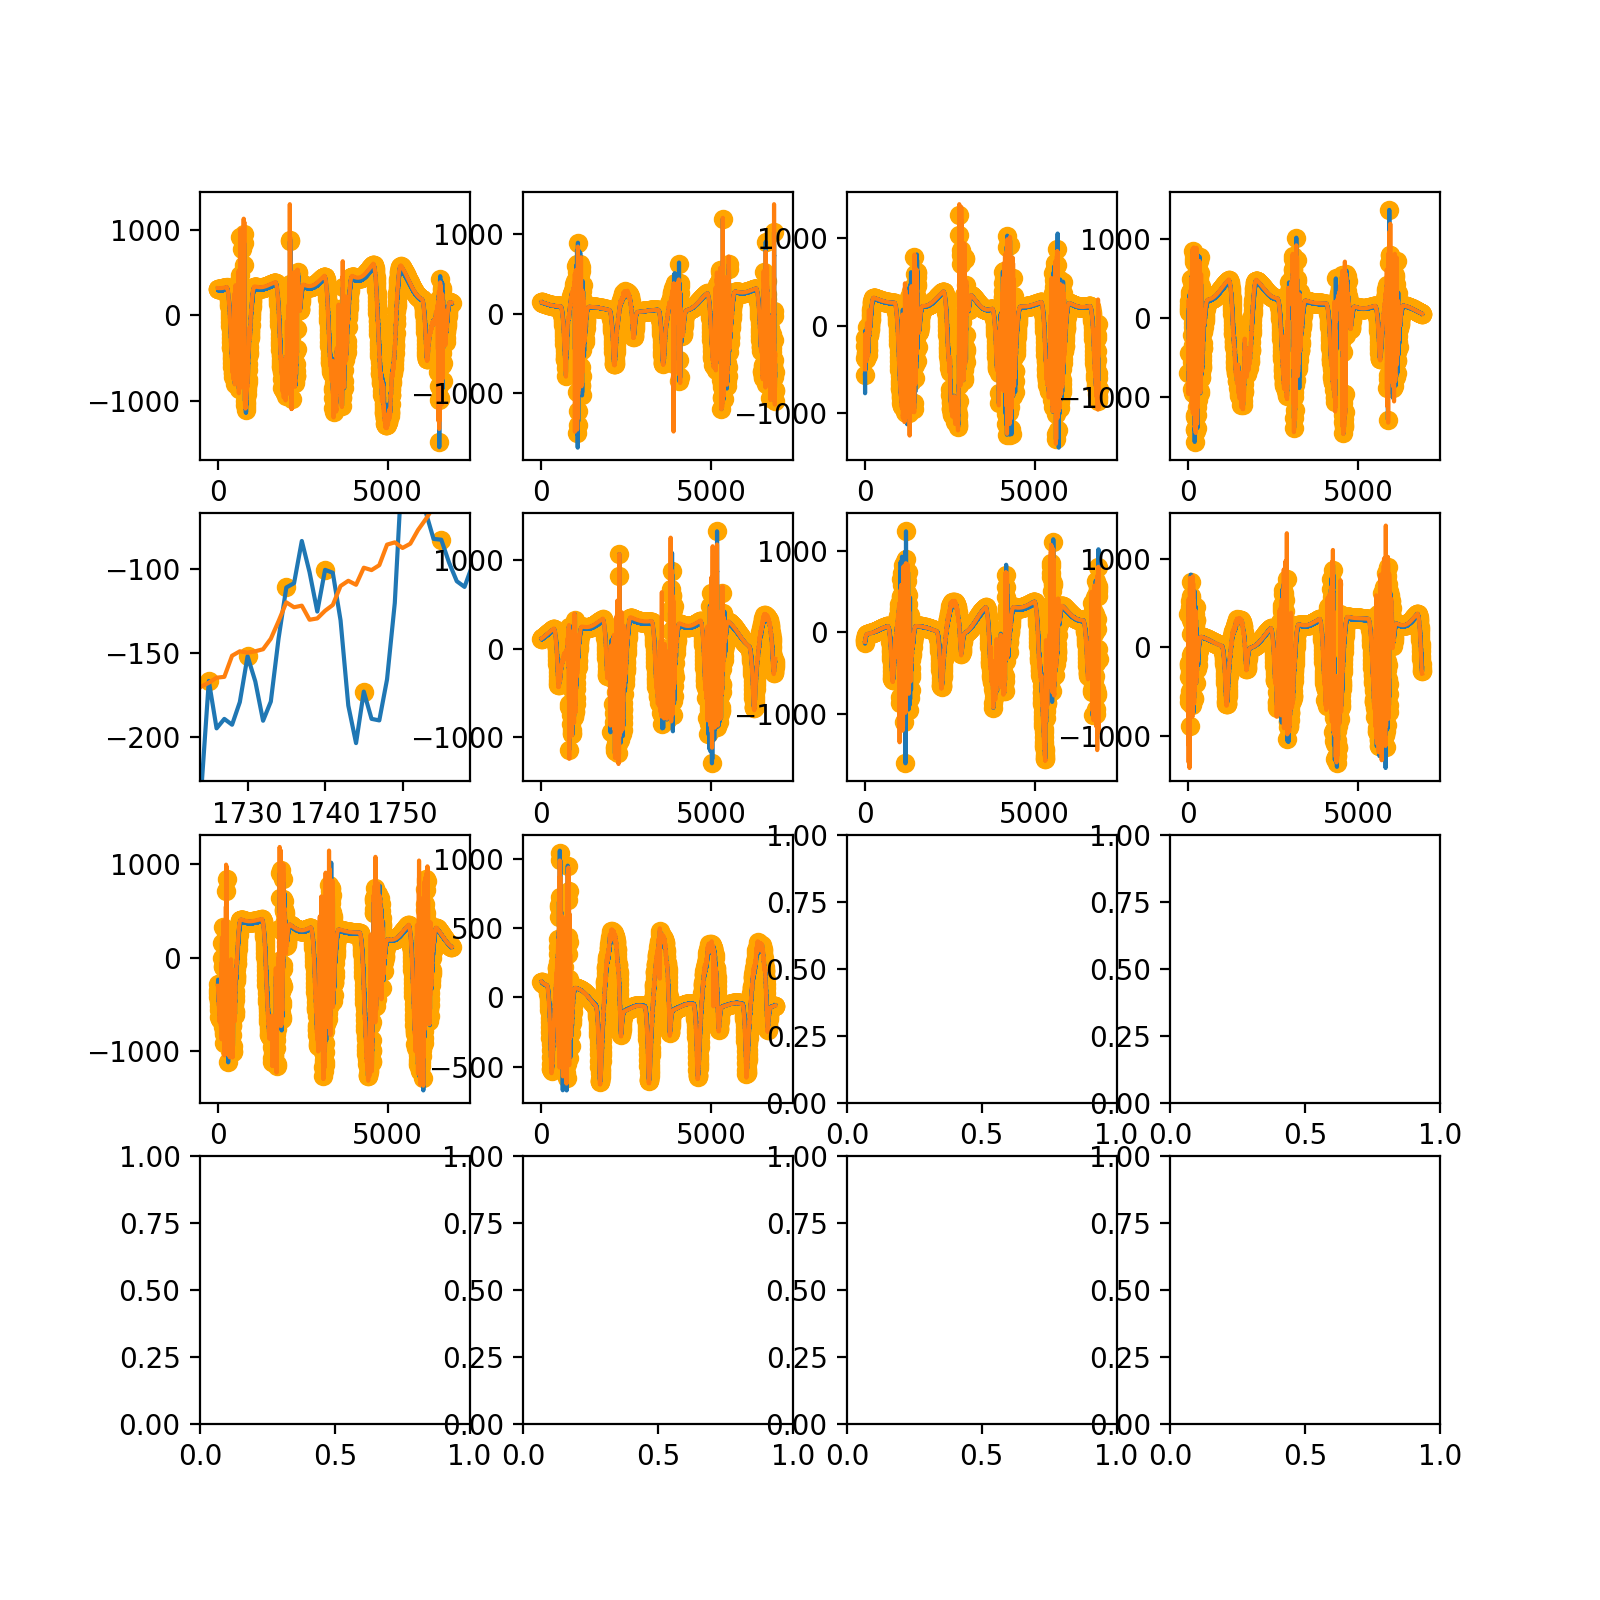

(6890,) (6890,)
(6890,) (6890,)
(6890,) (6890,)
(6890,) (6890,)
(6890,) (6890,)
(6890,) (6890,)
(6890,) (6890,)
(6890,) (6890,)
(6890,) (6890,)
(6890,) (6890,)


In [146]:
fig, axes = plt.subplots(math.ceil(10**0.5), math.ceil(10**0.5), figsize=(8, 8))
axes = axes.flatten()

for col in data.columns[:1]:
    for i, (pred, actual) in enumerate(zip(results[col], test_sets[col])):
        print(test.shape, actual.shape)
        axes[i].plot(pred)
        axes[i].plot(actual)
        axes[i].scatter(np.arange(0, len(test), 5), pred[np.arange(0, len(test), 5)], color='orange')

<IPython.core.display.Javascript object>


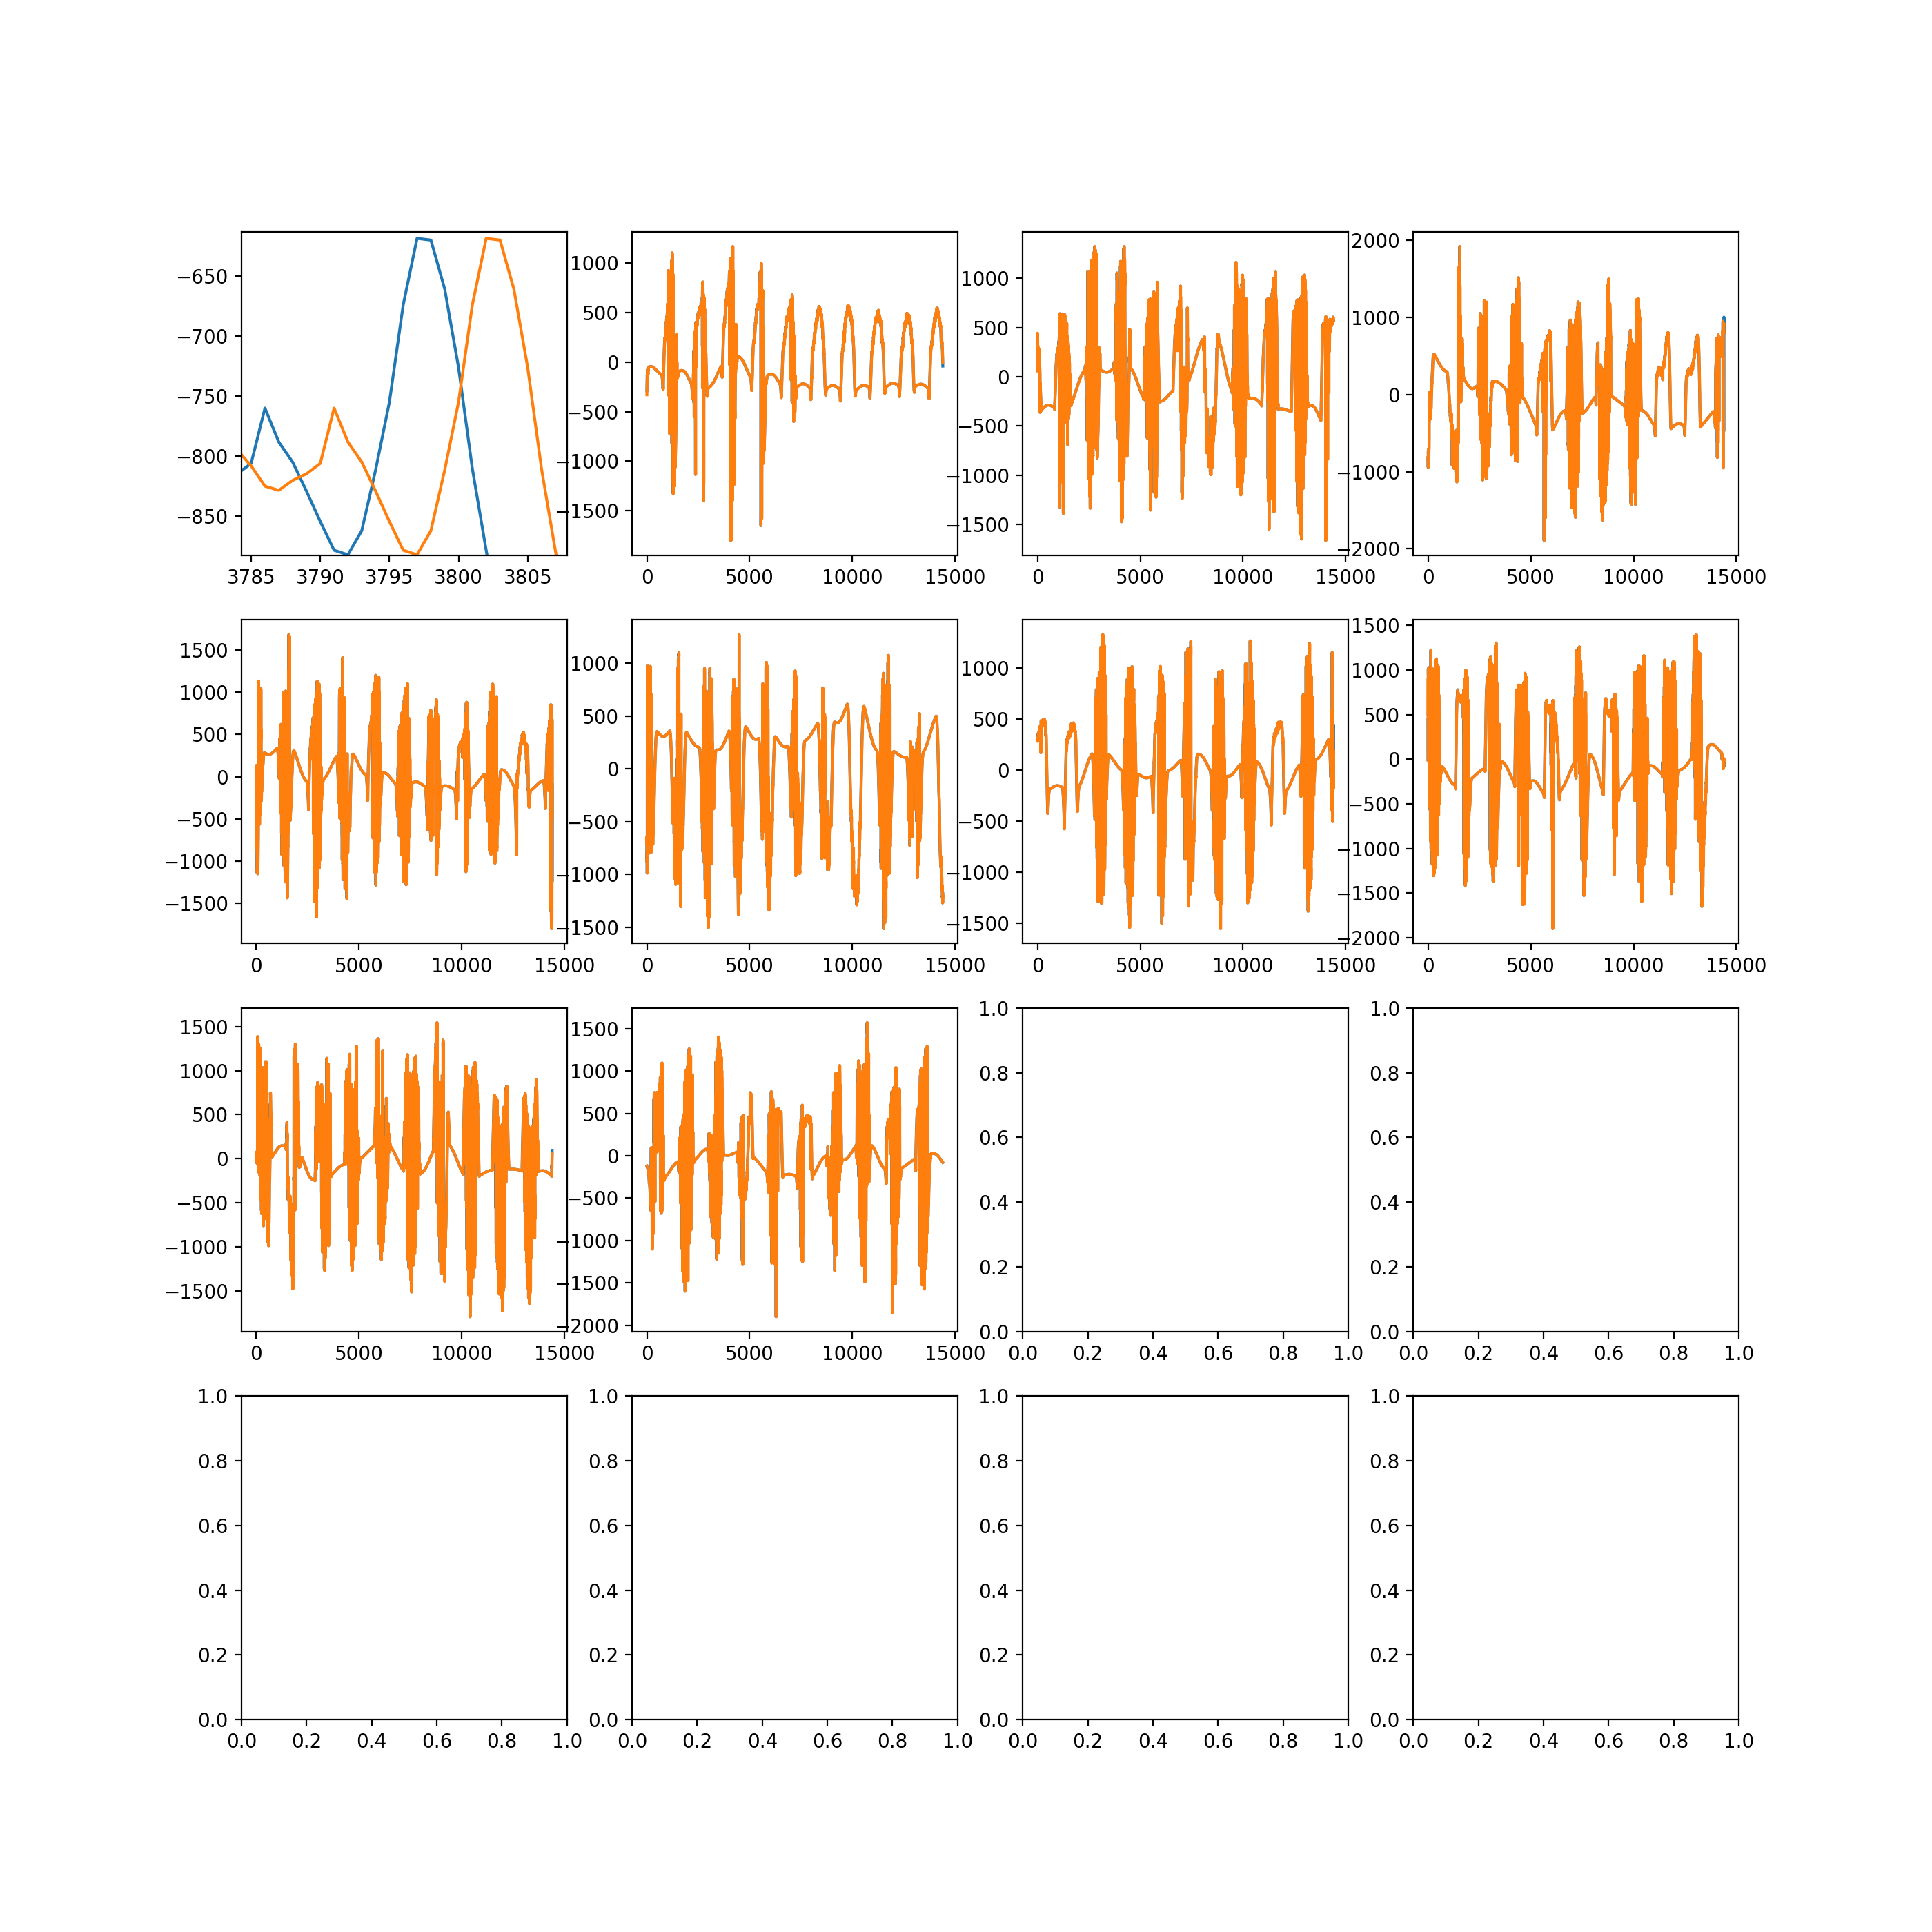

(14400,) (14400,)
(14400,) (14400,)
(14400,) (14400,)
(14400,) (14400,)
(14400,) (14400,)
(14400,) (14400,)
(14400,) (14400,)
(14400,) (14400,)
(14400,) (14400,)
(14400,) (14400,)


In [76]:
# Compute errors
from sklearn.metrics import mean_squared_error
from AutoValidator.ErrorMetrics import *
import math
%matplotlib notebook

bar = ProgressBar()
bar.set_length(len(data.columns) * 10)

metrics = {
    'RMSE' : lambda x, y: np.sqrt(mean_squared_error(x, y)),
#     'MASE' : lambda x, y: calculate_MASE(train[0]['window_1_0'], x, y)
}

fig, axes = plt.subplots(math.ceil(len(data.columns)**0.5), math.ceil(len(data.columns)**0.5), figsize=(14, 14))
axes = axes.flatten()

for col_ind, column in enumerate(data.columns):    
    col = data[column].values.flatten()
    indexer = np.arange(back_horizon)[None, :] + horizon * np.arange((len(col) - 2 * back_horizon) // horizon)[:, None]
    X = col[indexer]
    
    indexer = back_horizon + np.arange(horizon)[None, :] + horizon * np.arange((len(col) - 2 * back_horizon) // horizon)[:, None]
    y = col[indexer]
    
    # Only use most max_samples training samples
    max_samples = 20000
    X, y = X[len(X) - max_samples // horizon:], y[len(X) - max_samples // horizon:]

    actual_y = []
    actual_x = []
    for backtest_ind, (X_train, X_test, y_train, y_test) in enumerate(xy_backtest(X, y, 0.2, int(0.8 * len(X)) // 10)):
        actual_y += [y_test]
        actual_x += [X_test[:, -horizon:]]
        
    actual_y = np.vstack(actual_y).flatten()
    actual_x = np.vstack(actual_x).flatten()
    print(actual_x.shape, actual_y.shape)
    
#     pred = np.vstack([results['window_1_0']]).flatten()
    
#     for name, metric in metrics.items():
#         errors[repr(model) + '_' + name][column] = metric(pred, y_train)
#         print(name, metric(pred, actual))
        
    axes[col_ind].plot(actual_y)
    axes[col_ind].plot(actual_x)


In [52]:
errors

,"MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear', kernel_params=None), n_jobs=1)_RMSE",RMSE avg,RMSE std
window_1_0,170.150827,631.581426,0.0
window_1_1,587.853691,648.928617,0.0
window_1_2,580.014370,511.586775,0.0
window_1_3,577.931317,730.380337,0.0
window_1_4,585.415435,646.243145,0.0
window_1_5,678.958629,631.430254,0.0
window_1_6,556.728568,477.841500,0.0
window_1_7,601.243848,689.647864,0.0
window_1_8,610.959484,630.867446,0.0
window_1_9,564.367814,624.313624,0.0


In [41]:
p.shape

(14400,)

In [ ]:
# 15k samples - 66.71
# 20k samples - 65.75
# 30k samples - 71.18842889980372 mean on window_1_0

In [25]:
krr_thirty_min_tester.results[repr(model)] = results

In [26]:
krr_thirty_min_tester.results[repr(model)]['window_1_0'][0].shape

(1600,)

In [28]:
errors.head()

,"MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear', kernel_params=None), n_jobs=1)_RMSE","MultiOutputRegressor(estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear', kernel_params=None), n_jobs=1)_MASE",RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,631.581426,1.177195,631.581426,0.0,1.177195,0.0
window_1_1,648.928617,1.368995,648.928617,0.0,1.368995,0.0
window_1_2,511.586775,1.406001,511.586775,0.0,1.406001,0.0
window_1_3,730.380337,1.337237,730.380337,0.0,1.337237,0.0
window_1_4,646.243145,1.675905,646.243145,0.0,1.675905,0.0


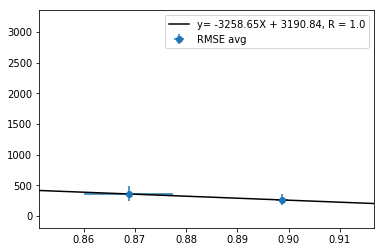

In [35]:
krr_thirty_min_tester.compare_hurst(hurst_estimates.loc[['window_1_0', 'window_1_1']], errors=errors)

In [41]:
test = np.vstack([x['window_1_0'] for x in krr_thirty_min_tester.test])

In [44]:
test = test.flatten()

In [48]:
test.shape

(69005,)

In [46]:
pred = np.vstack([x for x in results['window_1_0']])

In [49]:
pred = pred.flatten()

In [50]:
pred

array([310.75934499, 301.77711374, 297.10137425, ..., -58.99736274,
       -58.37771062, -57.6382084 ])

<IPython.core.display.Javascript object>


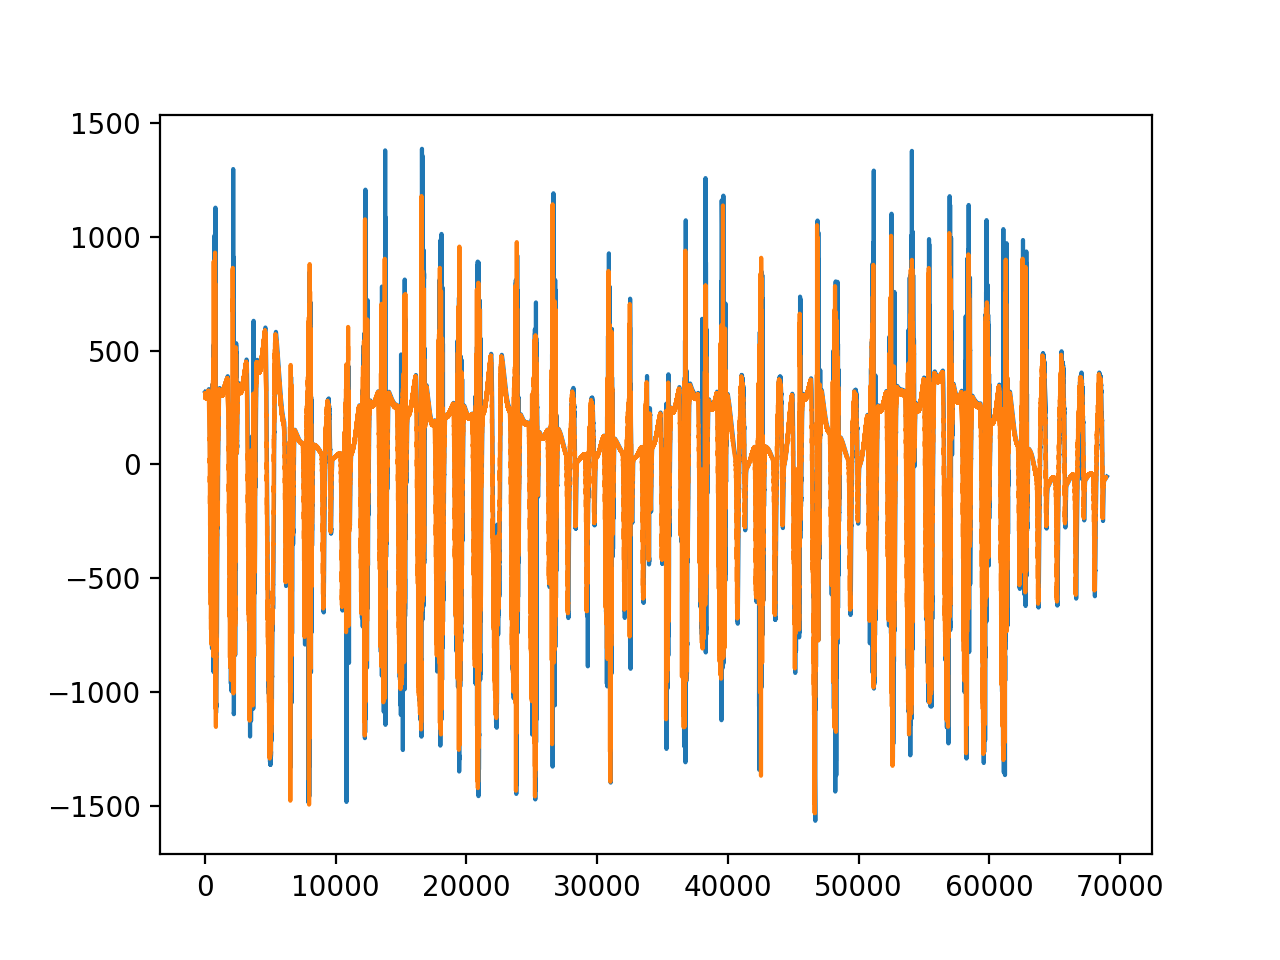

In [52]:
%matplotlib notebook
plt.plot(test)
plt.plot(pred)

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [4]:
model = GaussianProcessRegressor(n_restarts_optimizer=0, copy_X_train=False)

In [3]:
def xy_backtest(X, y, start, step_size):
    step = step_size
    start = int(start * len(X))
    splits = np.arange(start, len(X), step)
    
    results = []
    
    for test_start, test_end in zip(splits[:-1], splits[1:]):
        results.append((X[:test_start], X[test_start:test_end], y[:test_start], y[test_start:test_end]))
        
    return results

In [18]:
horizon = 5

In [23]:
%matplotlib notebook
for column in data.columns[:1]:
    col = data[column].values.flatten()
    indexer = np.arange(horizon)[None, :] + np.arange(len(col) - 2 * horizon)[:, None]
    X = col[indexer]
    
    y = col[np.arange(horizon, len(col) - horizon)]
    
    X, y = X[:1000], y[:1000]
    
    for (X_train, X_test, y_train, y_test) in xy_backtest(X, y, 0.6, int(0.8 * len(X)) // 4):
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        model.fit(X_train, y_train)
        mean, std = model.predict(X_test, return_std=True)
        
        plt.plot(y_test)
        plt.plot(mean)
        plt.fill_between(np.arange(len(mean)), mean + std, mean - std, alpha=0.2, color='k')
        plt.legend(['actual', 'pred'])
        break

(600, 5) (200, 5) (600,) (200,)


TypeError: predict() got an unexpected keyword argument 'return_std'